In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import scvi
import glob
import matplotlib.pyplot as plt
from scipy import sparse

sc.settings.n_jobs = 16
scvi.settings.num_threads = 16
%config InlineBackend.figure_format='retina'

Global seed set to 0
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


# Preprocess Anndata objects

## Prepare public data

In [2]:
h5ad_paths = sorted(glob.glob("/Users/pax/OneDrive - Karolinska Institutet/PhD/Injury_atlas/Anndata/*"))

In [4]:
def h5ad_sce(file_path):
    adata = sc.read_h5ad(file_path)
    
    # format the data to adopt the Anndata format fro SCE
    if 'logcounts' in adata.layers.keys():
        del adata.layers["logcounts"]
        del adata.uns
        del adata.obsm
    adata.layers["counts"] = adata.X.copy()
    adata.var['mt'] = adata.var_names.str.startswith('mt')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata.obs['Modality'] = "Expression"
    adata.obs['Tissue'] = 'DRG'
    adata.obs['Technology'] = '10x_GEX'
    adata.obs["celltype_scanvi"] = "Unknown"
    return adata

In [6]:
adatas = list(map(h5ad_sce, h5ad_paths))
adatas[1].obs.Technology = "inDrops"
adatas[1].obs.celltype_scanvi = adatas[1].obs.CellType

adatas[0].obs.celltype_scanvi[adatas[0].obs.CellType.isin(['SGC', 'Schwann', 'Macrophage', 'Pericytes','Endothelial', 'Smooth Muscle', 'Connective Tissue'])] =\
    adatas[0].obs.CellType[adatas[0].obs.CellType.isin(['SGC', 'Schwann', 'Macrophage', 'Pericytes','Endothelial', 'Smooth Muscle', 'Connective Tissue'])]
adatas[0].obs.celltype_scanvi[adatas[0].obs.celltype_scanvi == 'Schwann'] = 'Schwann_M'

adatas[2].obs['Source'] = 'Sharma'
adatas[2].obs['Sex'] = 'female'
adatas[2].obs["Conditions"] = "Naive"
adatas[2].obs["Time"] = "0day"
adatas[2].obs["Strains"] = "C57"
adatas[2].obs["Age"] = "Young"

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_524/647307336.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatas[0].obs.celltype_scanvi[adatas[0].obs.CellType.isin(['SGC', 'Schwann', 'Macrophage', 'Pericytes','Endothelial', 'Smooth Muscle', 'Connective Tissue'])] =\
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_524/647307336.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatas[0].obs.celltype_scanvi[adatas[0].obs.celltype_scanvi == 'Schwann'] = 'Schwann_M'


# Prepare Patch-seq data

In [7]:
count = pd.read_table("/Users/pax/OneDrive - Karolinska Institutet/PhD/Injury_atlas/Notebook/Patch-seq/GSE168032_tpm_counts.txt", sep="\t", index_col=0)
samp_tab = pd.read_table("/Users/pax/OneDrive - Karolinska Institutet/PhD/Injury_atlas/Notebook/Patch-seq/GSE168032_sampleTable_matrix.txt", sep="\t", index_col=0)

In [8]:
count = count.set_index('gene_symbol').iloc[:,2:]
count = count.T
count.sort_index(inplace=True)

In [9]:
patch_adata = sc.AnnData(count, obs=samp_tab)
patch_adata.var_names_make_unique()
sc.pp.filter_genes(patch_adata, min_cells=20)

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_524/1575633092.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  patch_adata = sc.AnnData(count, obs=samp_tab)
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [10]:
gene_len = patch_adata.to_df().sum(axis=0)
gene_len = gene_len.reindex(patch_adata.var.index).dropna()
assert (patch_adata.var.index == gene_len.index).sum() == patch_adata.shape[1]
patch_adata.X = patch_adata.X / gene_len.values * np.median(gene_len.values)
# round to integer
patch_adata.X = np.rint(patch_adata.X)

In [11]:
patch_adata.layers["counts"] = patch_adata.X.copy()
patch_adata.var['mt'] = patch_adata.var_names.str.startswith('mt')
sc.pp.calculate_qc_metrics(patch_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
patch_adata.obs['Modality'] = "Expression"
patch_adata.obs['Tissue'] = 'DRG'
patch_adata.obs['Technology'] = 'PatchSeq'
patch_adata.obs["celltype_scanvi"] = "Unknown"
patch_adata.obs["Conditions"] = "Naive"
patch_adata.obs["Time"] = "0day"
patch_adata.obs["Strains"] = "C57"
patch_adata.obs["Age"] = "Young"
patch_adata.obs["Sex"] = "male"
patch_adata.obs["Source"] = "Parpaite"

In [12]:
adatas = adatas + [patch_adata]

## Prepare Lab data

### Multiome

In [13]:
dir_list = sorted(glob.glob('/Users/pax/OneDrive - Karolinska Institutet/PhD/10x_multi_DRG/data/MO*'))
dir_list.pop(dir_list.index('/Users/pax/OneDrive - Karolinska Institutet/PhD/10x_multi_DRG/data/MO_22_005'))
dir_list.pop(dir_list.index('/Users/pax/OneDrive - Karolinska Institutet/PhD/10x_multi_DRG/data/MO_22_007'))
dir_list = dir_list[2:]
dir_name = [i.split('/')[-1] for i in dir_list]

In [14]:
condition_list = [
    'C57_CCI_14day_Old_Lab_female_Paired',
    'C57_Naive_0day_Old_Lab_female_Paired',
    'C57_Naive_0day_Young_Lab_female_Paired',
    'C57_Naive_0day_Young_Lab_male_Paired',
]

In [15]:
condition_dict = dict(zip(dir_name, condition_list))

In [16]:
def prepro(dir_path):
    key = dir_path.split('/')[-1]
    adata = scvi.data.read_10x_multiome(f'{dir_path}/raw_feature_bc_matrix')
    meta = pd.read_csv(f'{dir_path}/meta.csv', index_col=0)
    adata.obs = meta
    adata.var_names_make_unique()
    sc.pp.filter_genes(adata, min_cells=3)
    adata = adata[adata.obs.log1p_n_peaks_by_counts > 4]
    adata = adata[adata.obs.log1p_n_genes_by_counts > 4]
    adata = adata[adata.obs.log1p_n_peaks_by_counts < 9]
    adata = adata[adata.obs.log1p_n_genes_by_counts < 9]
    adata = adata[:,adata.var.modality == 'Gene Expression'] # only keep gene expression data
    adata.var['mt'] = adata.var_names.str.startswith('mt-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.pct_counts_mt < 1.5]
    adata = adata[adata.obs.total_counts < 20000]
    adata.obs['tmp'] = condition_dict[key]
    adata.obs[['Strains','Conditions','Time','Age','Source','Sex','Modality']] = adata.obs['tmp'].str.split('_', expand=True)
    del adata.obs['tmp']
    id = adata[adata[: , 'Uty'].X > 0, :].obs_names
    adata.obs.Sex.loc[id] = 'male'
    adata.layers["counts"] = adata.X.copy()
    adata.obs['Tissue'] = 'DRG'
    adata.obs['Technology'] = '10x_Multiome'
    adata.obs["celltype_scanvi"] = "Unknown"
    adata.obs['Source'] = "Lab_Multiome"
    return adata

In [17]:
adatas1 = list(map(prepro, dir_list))

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scvi/data/_read.py:76: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(data.tocsr(), var=features, obs=cell_annot)
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_524/2091886733.py:13: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('mt-')
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_524/2091886733.py:17: ImplicitModificationWarning: Trying to modify 

### SS3

In [18]:
adata_ss3 = sc.read_h5ad("./adata_drg_ss3_WT.h5ad")

In [19]:
adata_ss3.obs['Source'] = "Lab_SS3"
adata_ss3.obs['Modality'] = "Expression"
adata_ss3.obs['Conditions'] = "Naive"
adata_ss3.obs['Time'] = "0day"
adata_ss3.obs['Tissue'] = 'DRG'
adata_ss3.obs['Technology'] = 'SS3'
adata_ss3.obs["celltype_scanvi"] = "Unknown"
adata_ss3.obs['Strains'] = 'C57'
adata_ss3.obs['Age'] = 'Old'
adata_ss3.obs['Sex'] = 'female'
id = adata_ss3[adata_ss3[: , 'Uty'].X > 0, :].obs_names
adata_ss3.obs.Sex.loc[id] = 'male'
del adata_ss3.layers["umi"]
del adata_ss3.layers["read"]

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_524/562968886.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_ss3.obs.Sex.loc[id] = 'male'


# Combine adatas

In [38]:
adata = sc.concat((adatas + adatas1 + [adata_ss3]), join='outer')
adata.obs_names_make_unique()

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [40]:
adata.obs.Time = adata.obs.Time.astype('category')
adata.obs.Time = adata.obs.Time.cat.reorder_categories(['0day','0.25day','0.5day','1day','1.5day','2day','3day','7day','14day','28day','60day','90day'])

In [41]:
print(adata.shape)
sc.pp.filter_genes(adata, min_cells=250)
print(adata.shape)

(194029, 38467)
(194029, 19994)


In [42]:
adata = adata[:,~adata.var_names.str.startswith('rRNA')]
adata = adata[:,~adata.var_names.str.contains('ENSMUSG')]

In [43]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=3000,
    layer="counts",
    batch_key="Source",
    subset=False,
    span=0.6
)

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


In [45]:
adata = adata[:, (adata.var.highly_variable) | (adata.var_names == 'Prdm12')].copy()

In [61]:
del adata.layers["logcounts"]

In [62]:
adata.obs = adata.obs[['pct_counts_mt','total_counts','Source','Conditions','Strains','Time','Sex','Age',
                       'Technology','celltype_scanvi','mixed_currents','current_Type_1','current_Type_2']]

In [63]:
adata.write_h5ad('./Results_h5ad/01_adata_prep.h5ad')

# Train scVI model

In [3]:
adata = sc.read_h5ad('./Results_h5ad/01_adata_prep.h5ad')

In [64]:
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="Source")

In [65]:
vae = scvi.model.SCVI(adata, n_layers=5, n_latent=50, gene_likelihood="nb")

In [101]:
vae.view_anndata_setup(adata)

Anndata setup with scvi-tools version 0.20.3.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'Source',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   8    │
│         n_cells          │ 228957 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  3000  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃  Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Source'] │   Avraham    │          0          │
│                     │ Lab_Multiome │          1          │
│                     │   Lab_SS3    │          2          │
│                     │   Parpaite   │          3          │
│                     │   Renthal    │          4          │
│                     │    Sharma    │          5          │
│                     │     Wang     │          6          │
│                     │    Zhang     │          7          │
└─────────────────────┴──────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [102]:
vae.to_device(device='mps')

In [1]:
vae.train(max_epochs=100,early_stopping=True)

In [ ]:
vae.save('./scvi_model', save_anndata=True, overwrite=True)

In [4]:
vae = scvi.model.SCVI.load('./scvi_model')
vae.to_device('mps')

INFO     File ./scvi_model/model.pt already downloaded                                                             


/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_18246/619009434.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


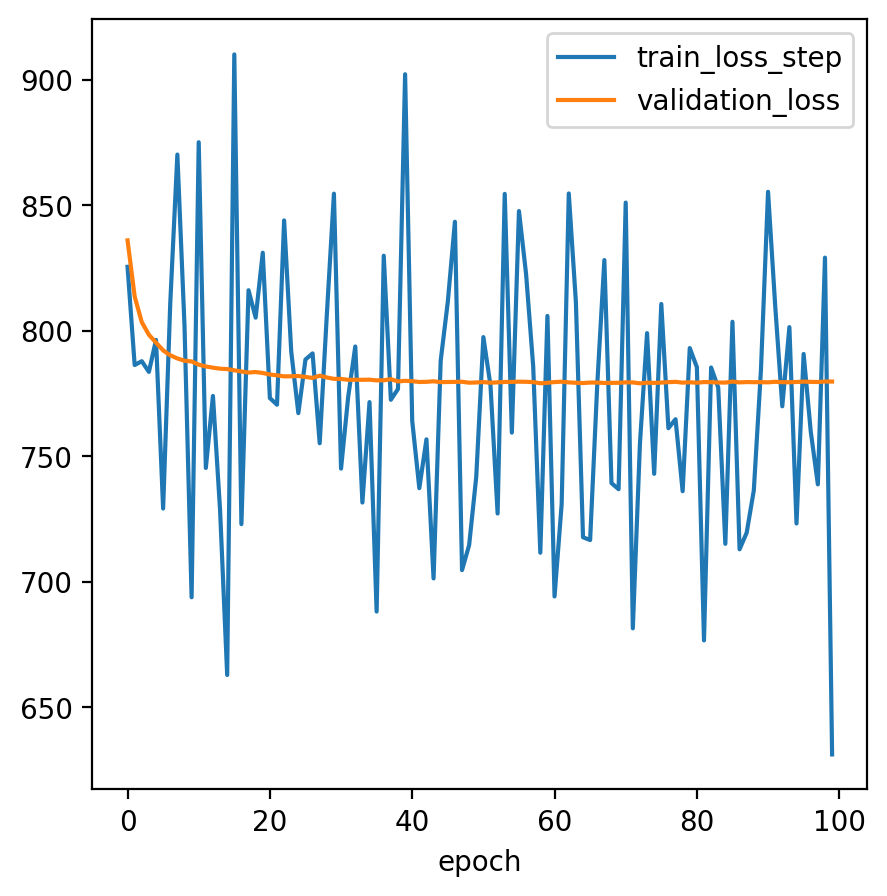

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
vae.history['train_loss_step'].plot(ax=ax, label='train loss')
vae.history['validation_loss'].plot(ax=ax, label='validation loss')
fig.show()

In [ ]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [ ]:
adata.layers["scVI_norm"] = vae.get_normalized_expression(library_size=1e4)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=100, use_rep="X_scVI")
sc.tl.leiden(adata, resolution=0.1)

In [ ]:
sc.tl.umap(adata, min_dist=0.5)
adata.obsm['X_umapSCVI'] = adata.obsm['X_umap']

In [ ]:
adata.write_h5ad("./Results_h5ad/01_injury_scVI.h5ad")

In [10]:
adata = sc.read_h5ad("./Results_h5ad/01_injury_scVI.h5ad")

# Train scANVI model to predict celltypes

In [56]:
adata.obs["celltype_scanvi"] = "Unknown"
renthal_mask = adata.obs["Source"] == "Renthal"
adata.obs["celltype_scanvi"][renthal_mask] = adata.obs.CellType[renthal_mask].values

In [25]:
np.unique(adata.obs["celltype_scanvi"], return_counts=True)

(array(['B cell', 'Connective Tissue', 'Endothelial', 'Fibroblast',
        'Macrophage', 'NF1', 'NF2', 'NF3', 'NP', 'Neutrophil', 'PEP1',
        'PEP2', 'Pericytes', 'Repair fibroblast', 'Repair schwann', 'SGC',
        'SST', 'Schwann_M', 'Schwann_N', 'Smooth Muscle', 'Unknown',
        'cLTMR1', 'p_cLTMR2'], dtype=object),
 array([  616,  3841,  5881, 14354,  8264, 15022, 17708,  2950, 18041,
          615, 11279,  6019,  2845,   701,  1824, 20543,  4279, 11190,
         8726,   992, 64877,  5036,  3000]))

In [11]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="celltype_scanvi",
    unlabeled_category='Unknown',
)
lvae.to_device('mps')

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [13]:
lvae.train(max_epochs=350, n_samples_per_label=128, early_stopping=True, plan_kwargs=dict(lr=1e-4))

In [ ]:
lvae.save('./scanvi_model', save_anndata=True, overwrite=True)

In [33]:
lvae = scvi.model.SCANVI.load('./scanvi_model')
lvae.to_device('mps')

INFO     File ./scanvi_model/model.pt already downloaded                                                           
